In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init
from torchsummary import summary

# Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ),(0.5, ))])

trainset = torchvision.datasets.CIFAR10(root='Data_CIFAF10',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1024,
                                          num_workers=5,
                                          shuffle=True,
                                          drop_last = True)

testset = torchvision.datasets.CIFAR10(root='Data_CIFAR10',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         num_workers=5,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


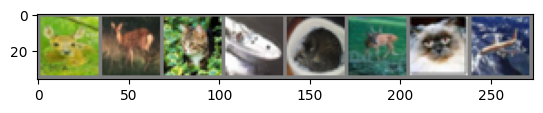

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

In [4]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=7)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(8*8*256, 128)
        self.dense2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.dense2(x)
        return x

In [5]:
model = CustomModel()
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           4,736
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 20, 20]         100,416
              ReLU-4           [-1, 64, 20, 20]               0
            Conv2d-5          [-1, 128, 14, 14]         401,536
              ReLU-6          [-1, 128, 14, 14]               0
            Conv2d-7            [-1, 256, 8, 8]       1,605,888
              ReLU-8            [-1, 256, 8, 8]               0
           Flatten-9                [-1, 16384]               0
           Linear-10                  [-1, 128]       2,097,280
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 4,211,146
Trainable params: 4,211,146
Non-trainable params: 0
---------------------------

# Loss, Optimizer and Evaluate Function

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=5e-5)

In [7]:
def evalute(model, testloader, loss_fn):
    model.eval()
    test_loss = 0.0
    running_correct = 0.0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
    
    accuracy = running_correct *100 / total
    loss = test_loss / len(testloader)
    return loss, accuracy

# Train

In [8]:
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

max_epoch = 20

In [9]:
for epoch in  range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0

    for i, (images, labels ) in enumerate(trainloader, 0):

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_accuracy = running_correct * 100 / total
    epoch_loss = running_loss / (i+1)
    train_accuracies.append(epoch_accuracy)
    train_losses.append(epoch_loss)

    test_loss, test_accuracy = evalute(model, testloader, loss_fn)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/20], Loss: 2.0909, Accuracy: 22.64%, Test Loss: 1.9235, Test Accuracy: 30.28%
Epoch [2/20], Loss: 1.8539, Accuracy: 32.53%, Test Loss: 1.7754, Test Accuracy: 35.77%
Epoch [3/20], Loss: 1.7432, Accuracy: 36.90%, Test Loss: 1.6813, Test Accuracy: 39.60%
Epoch [4/20], Loss: 1.6686, Accuracy: 39.25%, Test Loss: 1.6226, Test Accuracy: 41.51%
Epoch [5/20], Loss: 1.6084, Accuracy: 41.84%, Test Loss: 1.5751, Test Accuracy: 42.79%
Epoch [6/20], Loss: 1.5617, Accuracy: 43.67%, Test Loss: 1.5277, Test Accuracy: 45.11%
Epoch [7/20], Loss: 1.5198, Accuracy: 45.15%, Test Loss: 1.4973, Test Accuracy: 45.82%
Epoch [8/20], Loss: 1.4947, Accuracy: 46.19%, Test Loss: 1.4948, Test Accuracy: 46.25%
Epoch [9/20], Loss: 1.4725, Accuracy: 47.18%, Test Loss: 1.4433, Test Accuracy: 48.12%
Epoch [10/20], Loss: 1.4263, Accuracy: 48.66%, Test Loss: 1.4290, Test Accuracy: 48.32%
Epoch [11/20], Loss: 1.4111, Accuracy: 49.22%, Test Loss: 1.4023, Test Accuracy: 49.43%
Epoch [12/20], Loss: 1.3858, Accuracy: 50

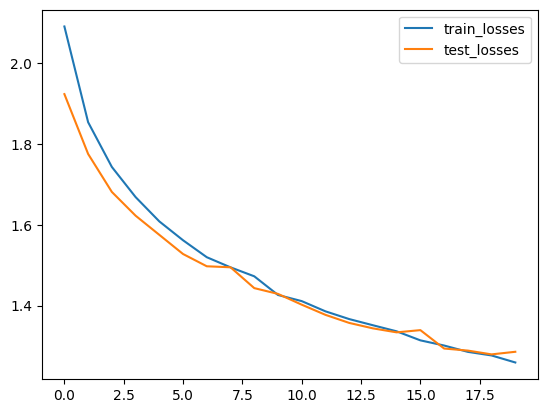

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

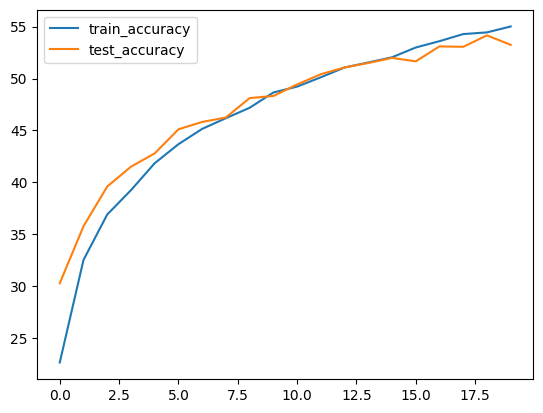

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()